# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy import stats
from scipy.stats import linregress
import importlib
import csv
import json


# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    # str.title(city)

    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# # Print the city count to confirm sufficient count
len(cities)

607

In [3]:
cities_df = pd.DataFrame(cities,columns=["City"])
print(cities_df)

             City
0     yellowknife
1          atuona
2     san quintin
3          hasaki
4     port alfred
..            ...
602  lappeenranta
603     mogadishu
604        arzgir
605   nuevo ideal
606         edson

[607 rows x 1 columns]


In [4]:
cities_df["ID"] = ""
cities_df["Lat"] = ""
cities_df["Lng"] = ""
cities_df["Max Temp"] = ""
cities_df["Humidity"] = ""
cities_df["Cloudiness"] = ""
cities_df["Wind Speed"] = ""
cities_df["Country"] = ""
cities_df["Date"] = ""

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it's being processed (with the city number and city name).


In [5]:
# Parameter for OpenWeather API
params = {"key": weather_api_key}

In [6]:
# Perform a weather check on each city using a series of successive API calls.

# Create empty list to store weather response
city = cities_df["City"]
citydata_df=pd.DataFrame(columns=["ID","Lat","Long","Max Temp","Humidity","Cloudiness","Wind","Country","Date"],index=city)
weather_response_list = []

# Loop for API call
for row in cities_df["City"]:

    base_url = "http://api.openweathermap.org/data/2.5/weather?"
    city = row
    query_url = base_url + "appid=" + weather_api_key + "&q=" + city + "&units=imperial"
    weather_response = requests.get(query_url).json()

    # Conditional to catch and skip any results that returns as "no city found"
    if weather_response['cod'] != 200:
        continue
    
    # Store variables and create DataFrame, drop any rows with "NaN"
    lat = weather_response['coord']['lat']
    lng = weather_response['coord']['lon']
    max_temp = weather_response['main']['temp_max']
    humidity = weather_response['main']['humidity']
    cloudiness = weather_response['clouds']['all']
    wind_speed = weather_response['wind']['speed']
    country = weather_response['sys']['country']
    city_id = weather_response['id']
    date_info =time.ctime(weather_response['dt'])

    citydata_df.loc[city]=[city_id,lat,lng,max_temp,humidity,cloudiness,wind_speed,country,date_info]

citydata_df.dropna(inplace=True)

print(citydata_df)

                   ID      Lat     Long Max Temp Humidity Cloudiness   Wind  \
City                                                                          
yellowknife   6185377   62.456 -114.353    67.96       43          5  12.17   
atuona        4020109     -9.8 -139.033    78.94       66          6  21.25   
san quintin   3984997  30.4833  -115.95     64.2       84          0  11.56   
hasaki        2112802  35.7333  140.833    79.18       81        100   8.34   
port alfred    964432 -33.5906   26.891     53.4       79         61   6.78   
...               ...      ...      ...      ...      ...        ...    ...   
lappeenranta   648900  61.0587  28.1887    64.45      100         90   3.44   
mogadishu       53654   2.0371  45.3438    77.77       83         81  14.85   
arzgir         580716  45.3728  44.2206    76.35       64         97  14.99   
nuevo ideal   3994607  24.8875 -105.073       72       30         11   6.73   
edson         5946820  53.5835 -116.436    68.29    

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [7]:
# Export city data to csv
citydata_df.to_csv("output_data/output.csv")

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [8]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Skipped as it's impossible to have humidity over 100%. Verified in data check.

In [9]:
# Create copy of edited city dataframe, named "clean_city_data".
clean_city_data = citydata_df
print(clean_city_data)

                   ID      Lat     Long Max Temp Humidity Cloudiness   Wind  \
City                                                                          
yellowknife   6185377   62.456 -114.353    67.96       43          5  12.17   
atuona        4020109     -9.8 -139.033    78.94       66          6  21.25   
san quintin   3984997  30.4833  -115.95     64.2       84          0  11.56   
hasaki        2112802  35.7333  140.833    79.18       81        100   8.34   
port alfred    964432 -33.5906   26.891     53.4       79         61   6.78   
...               ...      ...      ...      ...      ...        ...    ...   
lappeenranta   648900  61.0587  28.1887    64.45      100         90   3.44   
mogadishu       53654   2.0371  45.3438    77.77       83         81  14.85   
arzgir         580716  45.3728  44.2206    76.35       64         97  14.99   
nuevo ideal   3994607  24.8875 -105.073       72       30         11   6.73   
edson         5946820  53.5835 -116.436    68.29    

In [10]:
# Create new DataFrames for North and South Hemispheres
northern=clean_city_data.loc[clean_city_data["Lat"] >=0,]
n_hemi_data = pd.DataFrame(northern)

southern = clean_city_data.loc[clean_city_data["Lat"] < 0,]
s_hemi_data = pd.DataFrame(southern)

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

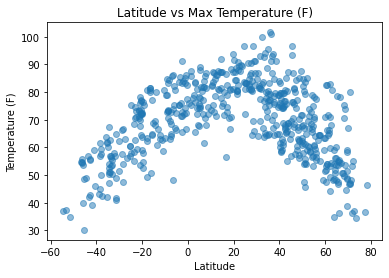

In [11]:
# Scatter Plot using full data set to calcuate for Lat vs Max Temp(F)
x_values = clean_city_data["Lat"]
y_values = clean_city_data["Max Temp"]
plt.xlabel("Latitude")
plt.ylabel("Temperature (F)")
plt.title("Latitude vs Max Temperature (F)")

plt.scatter(x_values, y_values, alpha=0.5)
plt.show()

### Analysis of Latitude vs Max Temperature Chart
The chart shows that the relationship between Latitude and Temperature follows a standard deviation curve, with few outliers. As expected, the weather gets warmer as you shift closer to the equator. The shift with warmer weather towards the Northern Hemisphere indicates that the measurements were taken during summertime.

## Latitude vs. Humidity Plot

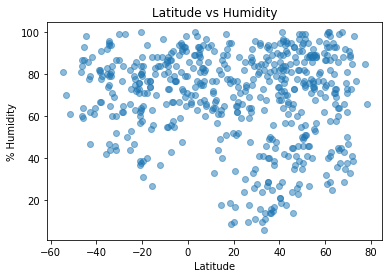

In [12]:
x_values = clean_city_data["Lat"]
y_values = clean_city_data["Humidity"]
plt.xlabel("Latitude")
plt.ylabel("% Humidity")
plt.title("Latitude vs Humidity")

plt.scatter(x_values, y_values, alpha=0.5)
plt.show()

### Analysis of Latitude vs Humidity Chart
This chart shows that the majority of the world has a high humidity rate, indicating a possible rainy season. The cluster of points showing lower humidity above the equator may indicate that the Northern Hemisphere is moving out of the rainy season and into summer.

## Latitude vs. Cloudiness Plot

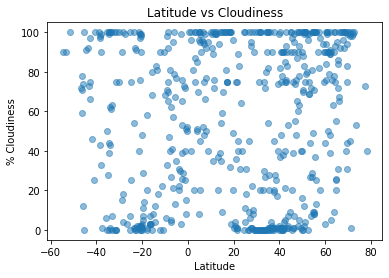

In [13]:
x_values = clean_city_data["Lat"]
y_values = clean_city_data["Cloudiness"]
plt.xlabel("Latitude")
plt.ylabel("% Cloudiness")
plt.title("Latitude vs Cloudiness")

plt.scatter(x_values, y_values, alpha=0.5)
plt.show()

### Analysis of Latitude vs Cloudiness Chart
Visible bands shown in this scatter plot show higher weather pressures systems existing in three main areas across the globe, with two lower pressure systems right on either side of the equator, demonstrating rising and falling air movement.

## Latitude vs. Wind Speed Plot

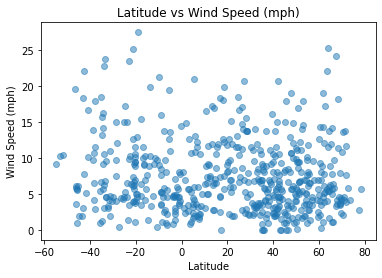

In [14]:
x_values = clean_city_data["Lat"]
y_values = clean_city_data["Wind"]
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title("Latitude vs Wind Speed (mph)")

plt.scatter(x_values, y_values, alpha=0.5)
plt.show()

### Analysis of Latitude vs Wind Speed Chart
This scatter chart shows a fairly consistent wind speed across all latitudes. Outliers at extremely high wind speeds likely indicate a major storm systems moving through that area. Loose comparison against the above cloudiness chart show correlation between the three bands of higher cloud cover and the three bands of higher wind speed as shown in this chart, further supporting that conclusion.

## Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

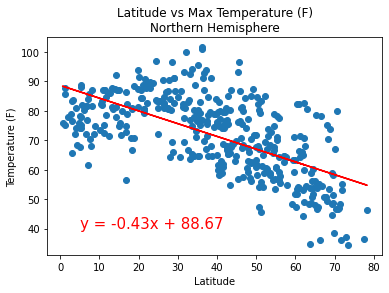

In [20]:
x_values = n_hemi_data["Lat"]
y_values = n_hemi_data["Max Temp"]
plt.xlabel("Latitude")
plt.ylabel("Temperature (F)")
plt.title("Latitude vs Max Temperature (F)\nNorthern Hemisphere")
slope, intercept, r_value, p_value, std_err = stats.linregress(x_values.astype(float), y_values.astype(float))
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5,40),fontsize=15,color="red")
nh_maxtemp = plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

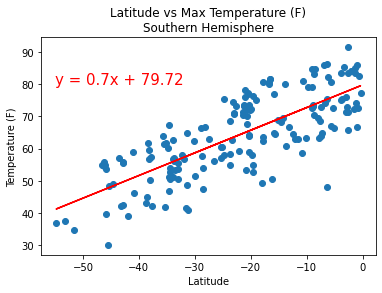

In [21]:
x_values = s_hemi_data["Lat"]
y_values = s_hemi_data["Max Temp"]
plt.xlabel("Latitude")
plt.ylabel("Temperature (F)")
plt.title("Latitude vs Max Temperature (F)\nSouthern Hemisphere")
slope, intercept, r_value, p_value, std_err = stats.linregress(x_values.astype(float), y_values.astype(float))
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-55,80),fontsize=15,color="red")
sh_maxtemp = plt.show()

### Northern vs Southern Hemisphere Temperature Analysis

Comparing these two charts, you can see that the weather gets warmer as we move towards the equator, and colder as we move away, as is expected. As the highest temperatures are between 20 and 40 degrees latitude, and north of the equator, we can assume that at this point, the northern hemisphere is entering the summer season.

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

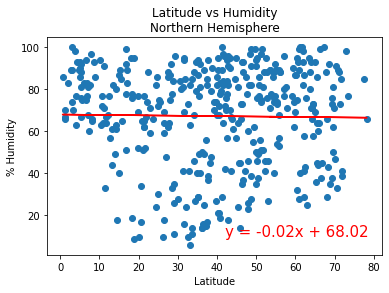

In [19]:
x_values = n_hemi_data["Lat"]
y_values = n_hemi_data["Humidity"]
plt.xlabel("Latitude")
plt.ylabel("% Humidity")
plt.title("Latitude vs Humidity\nNorthern Hemisphere")
slope, intercept, r_value, p_value, std_err = stats.linregress(x_values.astype(float), y_values.astype(float))
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(42,10),fontsize=15,color="red")
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

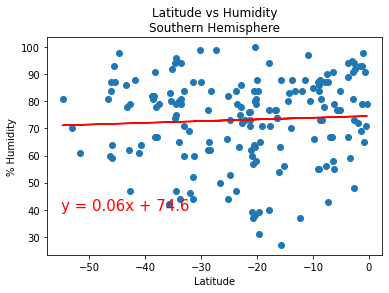

In [18]:
x_values = s_hemi_data["Lat"]
y_values = s_hemi_data["Humidity"]
plt.xlabel("Latitude")
plt.ylabel("% Humidity")
plt.title("Latitude vs Humidity\nSouthern Hemisphere")
slope, intercept, r_value, p_value, std_err = stats.linregress(x_values.astype(float), y_values.astype(float))
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-55,40),fontsize=15,color="red")
plt.show()

### Northern vs Southern Hemisphere Humidity Analysis

From these two charts, we can see that humidity levels are fairly consistent across the entire latitude range. However, with a significant number of outliers in the Northern Hemisphere chart, we can assume that weather is more volatile in the north, with a wider range of humidity levels.

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

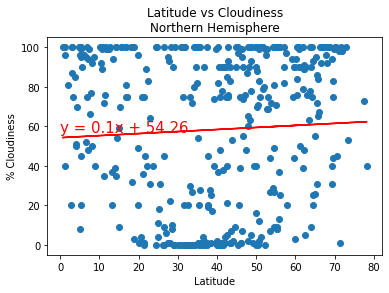

In [22]:
x_values = n_hemi_data["Lat"]
y_values = n_hemi_data["Cloudiness"]
plt.xlabel("Latitude")
plt.ylabel("% Cloudiness")
plt.title("Latitude vs Cloudiness\nNorthern Hemisphere")
slope, intercept, r_value, p_value, std_err = stats.linregress(x_values.astype(float), y_values.astype(float))
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,57),fontsize=15,color="red")
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

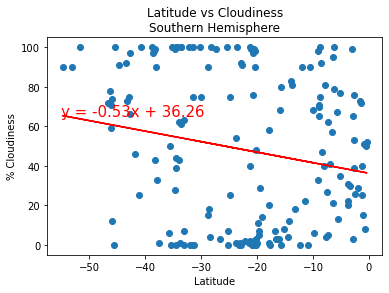

In [23]:
x_values = s_hemi_data["Lat"]
y_values = s_hemi_data["Cloudiness"]
plt.xlabel("Latitude")
plt.ylabel("% Cloudiness")
plt.title("Latitude vs Cloudiness\nSouthern Hemisphere")
slope, intercept, r_value, p_value, std_err = stats.linregress(x_values.astype(float), y_values.astype(float))
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-55,65),fontsize=15,color="red")
plt.show()

### Northern vs Southern Hemisphere Cloudiness Analysis

In comparing these two charts, we can see that there is greater volume of clouds in the northern hemisphere, with a more consistent linear regression pattern. This corresponds with the analysis made in the humidity charts comparison, showing more volatile weather patterns in the northern hemisphere.

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

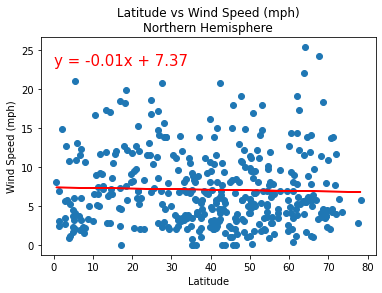

In [25]:
x_values = n_hemi_data["Lat"]
y_values = n_hemi_data["Wind"]
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title("Latitude vs Wind Speed (mph)\nNorthern Hemisphere")
slope, intercept, r_value, p_value, std_err = stats.linregress(x_values.astype(float), y_values.astype(float))
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0,23),fontsize=15,color="red")
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

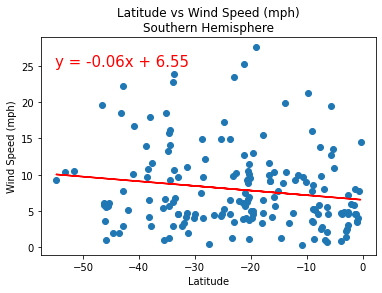

In [27]:
x_values = s_hemi_data["Lat"]
y_values = s_hemi_data["Wind"]
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title("Latitude vs Wind Speed (mph)\nSouthern Hemisphere")
slope, intercept, r_value, p_value, std_err = stats.linregress(x_values.astype(float), y_values.astype(float))
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-55,25),fontsize=15,color="red")
plt.show()

### Northern vs Southern Hemisphere Wind Speed Analysis

In comparing these two charts, we can see that wind speed is fairly consistent across all latitudes, with a small dip seen right at the equator. 

The fairly flat linear regression lines across Humidity, Cloudiness, and Wind Speed are all consistent with the analysis that air pressure and corresponding results fluctuate like a sine wave, with outliers at visual bands, but holding a fairly consistent average.

Lastly, it's interesting that there are so many more data sets taken in the Northern Hemisphere vs the Southen Hemisphere. This could be due to a difference in population density, or some other unknown variable that doesn't allow the same number of weather stations to be built in the same area.